<ipython-input-8-8f41542afdc6>:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Removed 4 invalid images.
Found 9996 files belonging to 10 classes.
Using 7997 files for training.
Found 9996 files belonging to 10 classes.
Using 1999 files for validation.
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 152s 580ms/step - accuracy: 0.6594 - loss: 1.0337 - val_accuracy: 0.8719 - val_loss: 0.4275
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 175s 472ms/step - accuracy: 0.8809 - loss: 0.3739 - val_accuracy: 0.8724 - val_loss: 0.4006
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 119s 477ms/step - accuracy: 0.9100 - loss: 0.2784 - val_accuracy: 0.8764 - val_loss: 0.3960
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 118s 472ms/step - accuracy: 0.9315 - loss: 0.2183 - val_accuracy: 0.8909 - val_loss: 0.3714
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 553ms/step - accuracy: 0.9443 - loss: 0.1778 - val_accuracy: 0.8834 - val_loss: 0.3945
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.8888 - loss: 0.3968
Validation Accuracy: 0.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms

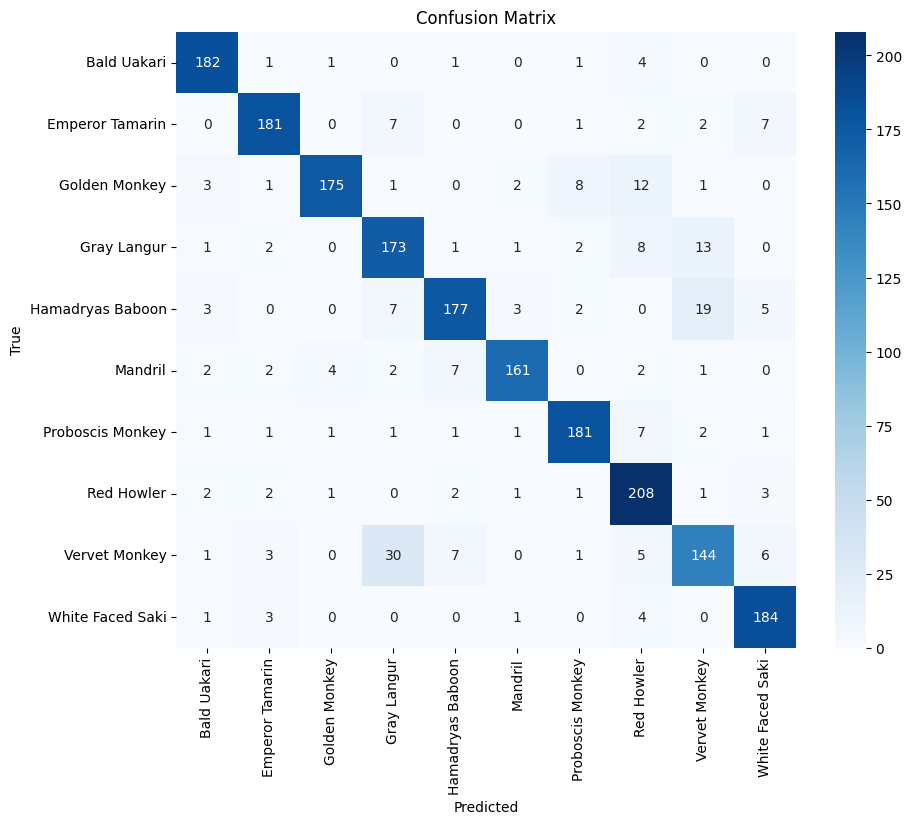

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import os
import zipfile
import imghdr
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Define dataset path
dataset_zip = "/content/Training Data.zip"
dataset_dir = "/content/Training Data"

# Extract ZIP file
if not os.path.exists(dataset_dir):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/")

# Remove invalid/corrupted images
def clean_invalid_images(directory):
    removed = []
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            if imghdr.what(filepath) not in ['jpeg', 'png', 'bmp', 'gif']:
                os.remove(filepath)
                removed.append(filepath)
    print(f"Removed {len(removed)} invalid images.")
    return removed

clean_invalid_images(dataset_dir)

# Parameters
img_size = (128, 128)
batch_size = 32
seed = 123

# Split into training and validation datasets
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize the pixel values
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

# Load pre-trained base model
base_model = keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(128, 128, 3)
)
base_model.trainable = False

# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
epochs = 5
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Evaluate
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2f}")

# Predict
true_labels = []
predicted_labels = []
predicted_probs = []

for images, labels in val_ds:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))
    predicted_probs.extend(preds)
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probs = np.array(predicted_probs)

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Z-Test
z_stat, z_p_value = stats.ttest_1samp(predicted_labels - true_labels, 0)
print(f"Z-Test: Z={z_stat:.2f}, p-value={z_p_value:.4f}")


Z-Test: Z=1.54, p-value=0.1234


In [ ]:
# T-Test
t_stat, t_p_value = stats.ttest_rel(predicted_labels, true_labels)
print(f"T-Test: T={t_stat:.2f}, p-value={t_p_value:.4f}")


T-Test: T=1.54, p-value=0.1234


In [ ]:
# ANOVA Test
anova_stat, anova_p_value = stats.f_oneway(predicted_labels, true_labels)
print(f"ANOVA Test: F={anova_stat:.2f}, p-value={anova_p_value:.4f}")


ANOVA Test: F=0.31, p-value=0.5771


In [ ]:
# Type 1 & Type 2 Errors
false_positives = np.sum((predicted_labels != true_labels) & (true_labels == 0))
false_negatives = np.sum((predicted_labels != true_labels) & (true_labels == 1))
total_samples = len(true_labels)

type1_error_rate = false_positives / total_samples
type2_error_rate = false_negatives / total_samples

print(f"Type 1 Error Rate: {type1_error_rate:.2f}")
print(f"Type 2 Error Rate: {type2_error_rate:.2f}")


Type 1 Error Rate: 0.00
Type 2 Error Rate: 0.01


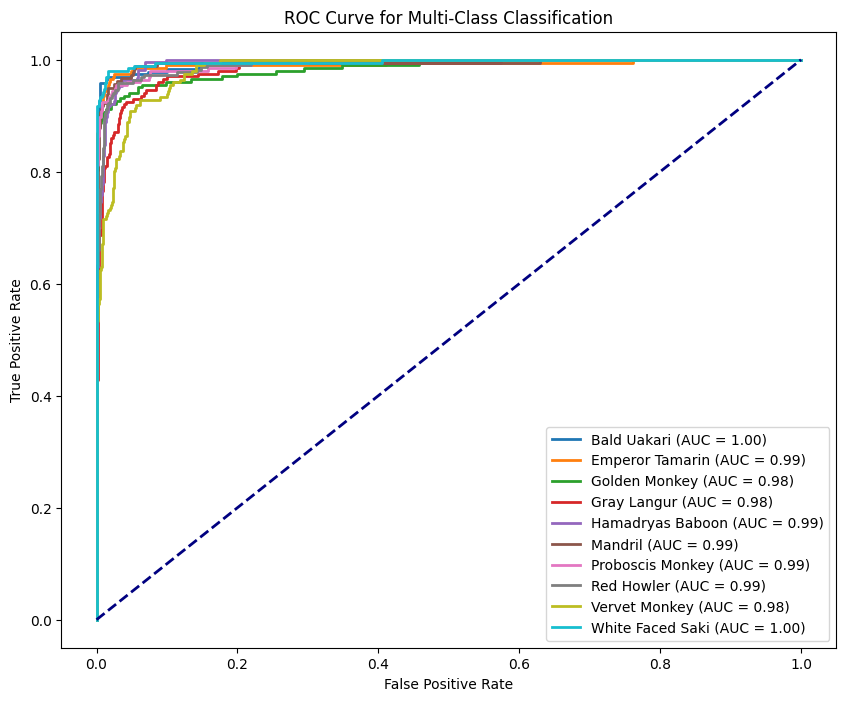

In [ ]:
# ROC Curve (One-vs-Rest for Multi-Class)
# Binarize the labels for multi-class ROC curve
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot ROC curve (Random Classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


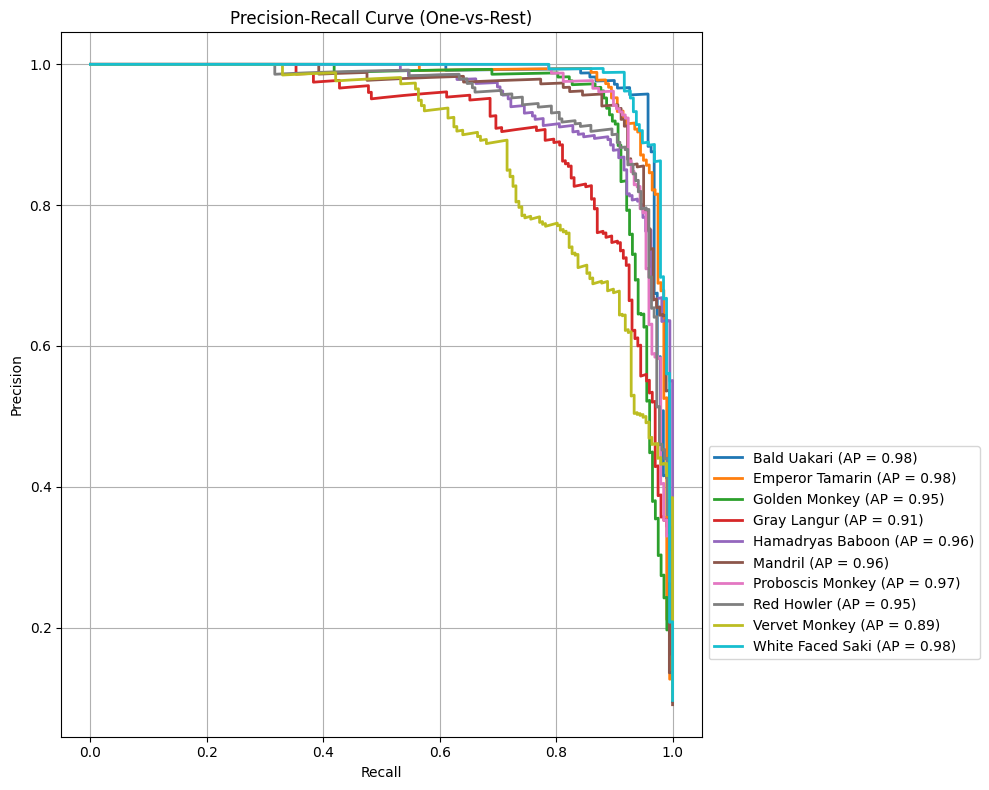

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], predicted_probs[:, i])
    avg_precision = average_precision_score(true_labels_bin[:, i], predicted_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc="lower left", bbox_to_anchor=(1.0, 0.1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Mean Average Precision
mean_ap = average_precision_score(true_labels_bin, predicted_probs, average="macro")
print(f"Mean Average Precision (mAP): {mean_ap:.2f}")


Mean Average Precision (mAP): 0.95
